In [ ]:
#https://github.com/jhu-lcsr/handeye_calib_camodocal

In [224]:
from scipy.spatial.transform import Rotation

from dust3r.inference import inference, load_model
from dust3r.image_pairs import make_pairs
from dust3r.utils.image import load_images, rgb
from dust3r.utils.device import to_numpy
from dust3r.viz import add_scene_cam, CAM_COLORS, OPENGL, pts3d_to_trimesh, cat_meshes
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode
import cv2

import matplotlib.pyplot as plt
from dust3r.utils.geometry import find_reciprocal_matches, xy_grid

In [225]:
import torch
import numpy as np
import os

import torch.nn as nn
import torch.optim as optim

import plotly.graph_objects as go

In [266]:
def get_file_paths(folder_path):
    file_paths = []  # List to store file paths
    # Walk through all files and directories in the specified folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)  # Create full file path
            file_paths.append(file_path)  # Add file path to list
    # Sort the list based on filenames
    file_paths.sort(key=lambda path: os.path.basename(path))
    return file_paths

def euler_to_rotation_matrix(roll, pitch, yaw):
    """
    Convert euler angles (roll, pitch, yaw) to a rotation matrix.
    """
    R_x = torch.tensor([[1, 0, 0],
                        [0, torch.cos(roll), -torch.sin(roll)],
                        [0, torch.sin(roll), torch.cos(roll)]])
    
    R_y = torch.tensor([[torch.cos(pitch), 0, torch.sin(pitch)],
                        [0, 1, 0],
                        [-torch.sin(pitch), 0, torch.cos(pitch)]])
    
    R_z = torch.tensor([[torch.cos(yaw), -torch.sin(yaw), 0],
                        [torch.sin(yaw), torch.cos(yaw), 0],
                        [0, 0, 1]])
    
    R = torch.matmul(R_z, torch.matmul(R_y, R_x))
    return R

def construct_transformation_matrices(batch):
    """
    Construct a batch of transformation matrices from a batch of roll, pitch, yaw, x, y, z.
    The input batch should have the shape (n, 6), where each row is (roll, pitch, yaw, x, y, z).
    The output will have the shape (n, 4, 4), representing the transformation matrices.
    """
    n = batch.size(0)
    transformation_matrices = torch.zeros((n, 4, 4))
    
    for i in range(n):
        roll, pitch, yaw, x, y, z = batch[i]
        rotation_matrix = euler_to_rotation_matrix(roll, pitch, yaw)
        transformation_matrix = torch.eye(4)
        transformation_matrix[:3, :3] = rotation_matrix
        transformation_matrix[:3, 3] = torch.tensor([x, y, z])
        transformation_matrices[i] = transformation_matrix
    
    return transformation_matrices

def residual_error(R, A, B):
    """
    Compute the residual error for the rotation matrix R.
    
    Parameters:
    R : torch.Tensor
        The estimated rotation matrix of shape (3, 3).
    A, B : torch.Tensor
        3D rotation tensors of shape (N, 3, 3) representing sequences of 
        transformations A and B respectively.
    
    Returns:
    error : float
        The average residual error.
    """
    N = A.shape[0]
    errors = []
    for i in range(N):
        RA = R.mm(A[i])
        BR = B[i].mm(R)
        error = (RA - BR).norm()
        errors.append(error.item())
    return sum(errors) / N

In [227]:
device="cuda"
model_path = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
model = load_model(model_path, device)

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [228]:
folder_path = 'imgs2'
file_paths = get_file_paths(folder_path)#[:4]

In [6]:
#file_paths[:4]

In [7]:
images = load_images(file_paths, size=512)

>> Loading a list of 6 images
 - adding imgs2/2bs2sslb3_block_0.jpg with resolution 640x480 --> 512x384
 - adding imgs2/2bs2sslb3_block_1.jpg with resolution 640x480 --> 512x384
 - adding imgs2/2bs2sslb3_block_2.jpg with resolution 640x480 --> 512x384
 - adding imgs2/2bs2sslb3_block_3.jpg with resolution 640x480 --> 512x384
 - adding imgs2/2bs2sslb3_block_4.jpg with resolution 640x480 --> 512x384
 - adding imgs2/2bs2sslb3_block_5.jpg with resolution 640x480 --> 512x384
 (Found 6 images)


In [10]:
schedule = 'cosine'
lr = 0.01
niter = 3000
batch_size = 3

In [9]:
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference(pairs, model, device, batch_size=batch_size)

>> Inference with model on 30 image pairs


100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]


In [11]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)

In [12]:
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

 init edge (3*,4*) score=41.58988571166992
 init edge (3,1*) score=37.698280334472656
 init edge (3,5*) score=37.479286193847656
 init edge (3,2*) score=32.880157470703125
 init edge (0*,3) score=29.139493942260742
 init loss = 0.005355508998036385


100%|███████| 3000/3000 [01:59<00:00, 25.05it/s, lr=1.00274e-06 loss=0.00325074]


In [229]:
imgs = scene.imgs
focals = scene.get_focals()
poses = torch.linalg.inv(scene.get_im_poses())
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

In [313]:
poses

tensor([[[ 0.5024, -0.6802,  0.5338, -0.1322],
         [ 0.6131,  0.7156,  0.3347, -0.0624],
         [-0.6096,  0.1591,  0.7766,  0.0688],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.4165, -0.7083,  0.5700, -0.1288],
         [ 0.6920,  0.6536,  0.3065, -0.0741],
         [-0.5896,  0.2667,  0.7623,  0.0586],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9970, -0.0442,  0.0631, -0.0049],
         [ 0.0378,  0.9944,  0.0990, -0.0042],
         [-0.0672, -0.0963,  0.9931,  0.0174],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9996,  0.0273, -0.0079,  0.0000],
         [-0.0273,  0.9996,  0.0042,  0.0000],
         [ 0.0080, -0.0040,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9996,  0.0282, -0.0092,  0.0080],
         [-0.0281,  0.9996,  0.0094,  0.0084],
         [ 0.0095, -0.0092,  0.9999, -0.0119],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9996,  0.0281, -0.0015,  0.0152],
   

In [231]:
pts3d[1].reshape((-1,3))

tensor([[-0.3631,  0.1231,  0.2513],
        [-0.3677,  0.1242,  0.2537],
        [-0.3633,  0.1221,  0.2527],
        ...,
        [ 0.1077, -0.0268,  0.2586],
        [ 0.1077, -0.0270,  0.2589],
        [ 0.0998, -0.0191,  0.3126]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [232]:
pts_list=[]
for i in range(len(imgs)):
    sel_pts=pts3d[i][confidence_masks[i]]
    pts_list.append(sel_pts)

In [233]:
pts_tor=torch.cat(pts_list)

In [234]:
def extract_positions_directions(transform_matrices):
    positions = transform_matrices[:, :3, 3]
    forward_directions = transform_matrices[:, :3, 2]  # Negate if your camera looks along the -Z axis
    return positions, forward_directions

In [235]:
positions, directions = extract_positions_directions(poses)

In [236]:
positions=positions.detach().cpu()
directions=directions.detach().cpu()

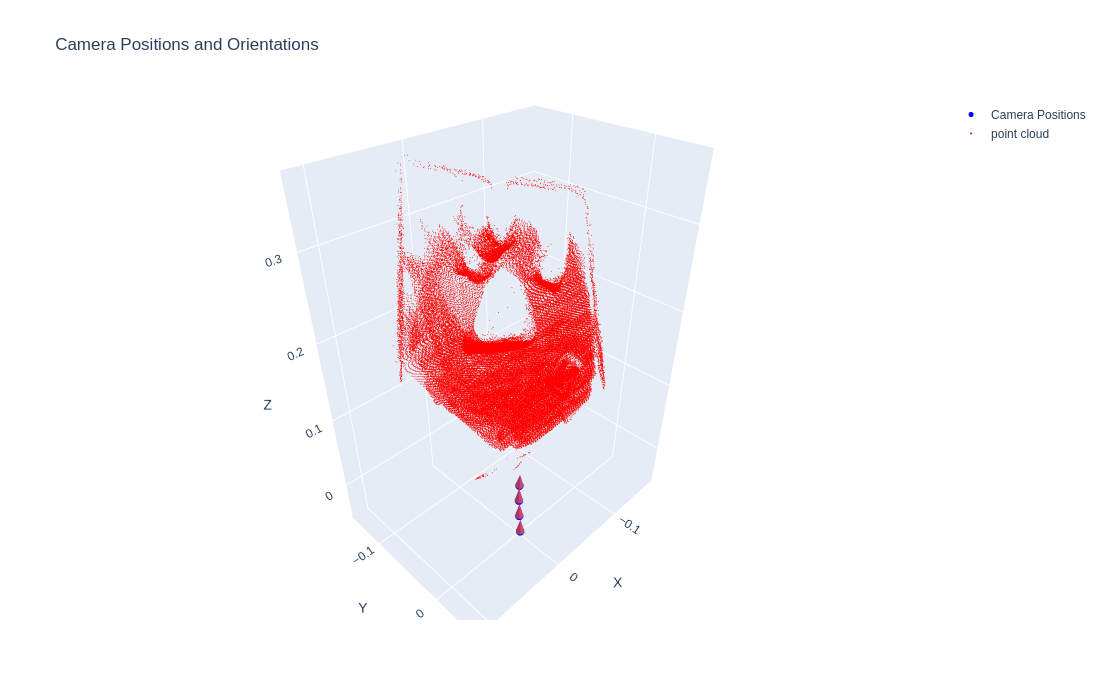

In [237]:
fig = go.Figure()

# Camera positions
fig.add_trace(go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                           mode='markers', marker=dict(size=5, color='blue'), name='Camera Positions'))

fig.add_trace(go.Scatter3d(x=pts_tor[::10, 0].detach().cpu(),  # X coordinates
    y=pts_tor[::10, 1].detach().cpu(),  # Y coordinates
    z=pts_tor[::10, 2].detach().cpu(),  # Z coordinates
                           mode='markers', marker=dict(size=0.5, color='red'),name="point cloud"))

# Directions
for position, direction in zip(positions, directions):
    fig.add_trace(go.Cone(x=[position[0]], y=[position[1]], z=[position[2]],
                          u=[direction[0]], v=[direction[1]], w=[direction[2]],
                          anchor="tail", showscale=False, sizeref=0.02))

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title="Camera Positions and Orientations")

fig.update_layout(width=1000, height=700)
fig.show()

In [238]:
scale_factor=(0.05)/(0.5*(torch.norm(positions[3]-positions[4])+torch.norm(positions[4]-positions[5])))

In [390]:
scale_factor

tensor(2.9925)

In [239]:
torch.norm(positions[3]-positions[4])

tensor(0.0166)

In [240]:
torch.norm(positions[5]-positions[4])

tensor(0.0169)

In [267]:
eef_poses = [
            [3.008, -0.668, 0.549, -0.16574, -0.268, 0.5065], # right back 0
            [3.008, -0.5914, 0.633, -0.111, -0.2634, 0.485], # right back 1
            [-3.008, -0.668, -0.549, -0.16574, 0.268, 0.5065], # left back 0
            [-3.008, -0.5914, -0.633, -0.111, 0.2634, 0.485], # left back 1

            [-3.008, -0.5914, -0.633, -0.061, 0.2634, 0.485], # left back x + 5cm
            [-3.008, -0.5914, -0.633, -0.011, 0.2634, 0.485], # left back x + 10cm

]
eef_poses_6d=torch.tensor(eef_poses)

In [268]:
eef_mats=construct_transformation_matrices(eef_poses_6d)#[:4] # only use top 4 as the end-effector is now not consistent

In [269]:
poses_scaled=poses.clone()
poses_scaled[:,:3,3]=poses_scaled[:,:3,3]*scale_factor

In [270]:
poses_scaled

tensor([[[ 0.5024, -0.6802,  0.5338, -0.3957],
         [ 0.6131,  0.7156,  0.3347, -0.1869],
         [-0.6096,  0.1591,  0.7766,  0.2059],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.4165, -0.7083,  0.5700, -0.3855],
         [ 0.6920,  0.6536,  0.3065, -0.2217],
         [-0.5896,  0.2667,  0.7623,  0.1755],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9970, -0.0442,  0.0631, -0.0147],
         [ 0.0378,  0.9944,  0.0990, -0.0125],
         [-0.0672, -0.0963,  0.9931,  0.0520],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9996,  0.0273, -0.0079,  0.0000],
         [-0.0273,  0.9996,  0.0042,  0.0000],
         [ 0.0080, -0.0040,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9996,  0.0282, -0.0092,  0.0239],
         [-0.0281,  0.9996,  0.0094,  0.0250],
         [ 0.0095, -0.0092,  0.9999, -0.0355],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9996,  0.0281, -0.0015,  0.0455],
   

In [320]:
# world-space coordinates to camera pose
poses_scaled_np=np.array(poses_scaled.cpu().detach())
#poses_scaled_np=np.array(poses_scaled.cpu().detach())

In [361]:
# robot base to manipulator end-effector pose
#eef_mats_np=np.array(eef_mats.cpu().detach())
eef_mats_np=np.array(torch.linalg.inv(eef_mats).cpu().detach())

In [362]:
eef_mats_np[:,:3,3]

array([[-0.09294729, -0.21702743,  0.54781   ],
       [-0.0667498 , -0.21724218,  0.5150494 ],
       [-0.09294729,  0.21702743,  0.54781   ],
       [-0.0667498 ,  0.21724218,  0.5150494 ],
       [-0.10021593,  0.24356331,  0.4888346 ],
       [-0.13368207,  0.26988447,  0.4626198 ]], dtype=float32)

In [363]:
poses_scaled_np[:,:3,3]

array([[-0.39569378, -0.18687943,  0.20593457],
       [-0.3854816 , -0.22170378,  0.17546731],
       [-0.01471334, -0.01253986,  0.05196914],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.02387008,  0.02502014, -0.03546764],
       [ 0.04546916,  0.05072615, -0.0731422 ]], dtype=float32)

In [364]:
eef_mats_np[:,:3,3]

array([[-0.09294729, -0.21702743,  0.54781   ],
       [-0.0667498 , -0.21724218,  0.5150494 ],
       [-0.09294729,  0.21702743,  0.54781   ],
       [-0.0667498 ,  0.21724218,  0.5150494 ],
       [-0.10021593,  0.24356331,  0.4888346 ],
       [-0.13368207,  0.26988447,  0.4626198 ]], dtype=float32)

In [365]:
import cv2

In [366]:
#https://docs.opencv.org/4.5.4/d9/d0c/group__calib3d.html#gaebfc1c9f7434196a374c382abf43439b

In [367]:
eef_mats_np.shape

(6, 4, 4)

In [368]:
eef_mats_np.shape

(6, 4, 4)

In [393]:
eef_mats_np[:3,:3,3]

array([[-0.09294729, -0.21702743,  0.54781   ],
       [-0.0667498 , -0.21724218,  0.5150494 ],
       [-0.09294729,  0.21702743,  0.54781   ]], dtype=float32)

In [394]:
rot,tr=cv2.calibrateHandEye(eef_mats_np[:,:3,:3],eef_mats_np[:,:3,3],
        poses_scaled_np[:,:3,:3],poses_scaled_np[:,:3,3],method=cv2.CALIB_HAND_EYE_TSAI)

In [395]:
rot

array([[ 0.12149456, -0.8717479 ,  0.47465216],
       [ 0.99252004,  0.10093348, -0.06867605],
       [ 0.01195991,  0.47944555,  0.87749013]])

In [396]:
tr

array([[ 0.2428602 ],
       [-0.01231119],
       [-1.24074854]])

In [373]:
pose_tor_n=torch.tensor(poses_scaled_np).cuda()

In [374]:
pts_tor_sel=pts_tor[::20]

In [375]:
(pose_tor_n[0,:3,:3]@(pts_tor_sel.T)).T

tensor([[ 0.1238, -0.0531,  0.3239],
        [ 0.1237, -0.0524,  0.3241],
        [ 0.1790, -0.0261,  0.2343],
        ...,
        [ 0.0783,  0.0905,  0.1242],
        [ 0.0808,  0.0938,  0.1211],
        [ 0.0831,  0.0968,  0.1177]], device='cuda:0',
       grad_fn=<PermuteBackward0>)

In [376]:
tr

array([[ 0.06427708],
       [-0.10087365],
       [-0.49238687]])

In [377]:
rot,tr=cv2.calibrateHandEye(eef_mats_np[:,:3,:3],eef_mats_np[:,:3,3],
        poses_scaled_np[:,:3,:3],poses_scaled_np[:,:3,3],method=cv2.CALIB_HAND_EYE_HORAUD)

In [378]:
rot

array([[ 0.06682565, -0.87875699,  0.47256797],
       [ 0.99775964,  0.05735172, -0.03444523],
       [ 0.0031664 ,  0.47381107,  0.88062083]])

In [379]:
tr

array([[ 0.24311125],
       [-0.03856909],
       [-1.23898545]])

In [380]:
rot,tr=cv2.calibrateHandEye(eef_mats_np[:,:3,:3],eef_mats_np[:,:3,3],
        poses_scaled_np[:,:3,:3],poses_scaled_np[:,:3,3],method=cv2.CALIB_HAND_EYE_DANIILIDIS)

In [381]:
rot

array([[ 0.2037338 , -0.86013544,  0.46761049],
       [ 0.97838065,  0.16153103, -0.12914731],
       [ 0.03555058,  0.48381273,  0.8744492 ]])

In [382]:
tr

array([[ 0.42361186],
       [ 0.03366625],
       [-2.05419657]])

In [383]:
eef_mats_np

array([[[ 0.6696947 ,  0.40967247,  0.6194171 , -0.09294729],
        [ 0.44680524, -0.88849914,  0.10456692, -0.21702743],
        [ 0.5931897 ,  0.20673089, -0.77806693,  0.54781   ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.66932255,  0.49109516,  0.55752385, -0.0667498 ],
        [ 0.5264228 , -0.84300214,  0.11057393, -0.21724218],
        [ 0.5242961 ,  0.21948366, -0.822764  ,  0.5150494 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.6696947 , -0.40967247,  0.6194171 , -0.09294729],
        [-0.44680524, -0.88849914, -0.10456692,  0.21702743],
        [ 0.5931897 , -0.20673089, -0.77806693,  0.54781   ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.66932255, -0.49109516,  0.55752385, -0.0667498 ],
        [-0.5264228 , -0.84300214, -0.11057393,  0.21724218],
        [ 0.5242961 , -0.21948366, -0.822764  ,  0.5150494 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],



In [384]:
rot,tr=cv2.calibrateHandEye(eef_mats_np[:,:3,:3],eef_mats_np[:,:3,3],
        poses_scaled_np[:,:3,:3],poses_scaled_np[:,:3,3],method=cv2.CALIB_HAND_EYE_ANDREFF)

In [385]:
rot

array([[ 0.25614643, -0.85197343,  0.45665116],
       [ 0.96615514,  0.21071914, -0.14880085],
       [ 0.03054923,  0.47931067,  0.87711346]])

In [386]:
tr

array([[ 0.48481924],
       [-0.01500429],
       [-0.47994668]])

In [387]:
torch.tensor(eef_mats_np[:,:3,:3]).float()[2]@torch.tensor(rot).float()

tensor([[-0.2053, -0.3600,  0.9101],
        [-0.9761,  0.1433, -0.1635],
        [-0.0716, -0.9219, -0.3808]])

In [388]:
torch.tensor(rot).float()@torch.tensor(poses_scaled_np[:,:3,:3]).float()[2]

tensor([[ 0.1925, -0.9025,  0.3853],
        [ 0.9812,  0.1811, -0.0659],
        [-0.0103,  0.3908,  0.9204]])

In [389]:
residual_error(torch.tensor(rot).float(),
               torch.tensor(eef_mats_np[:,:3,:3]).float(),
               torch.tensor(poses_scaled_np[:,:3,:3]).float()
               )

2.7073330879211426

In [312]:
torch.tensor(eef_mats_np[:,:3,:3]).float()@torch.tensor(rot).float().T

tensor([[[-0.1137, -0.6377, -0.7618],
         [ 0.3476, -0.7439,  0.5708],
         [-0.9307, -0.1999,  0.3062]],

        [[-0.2008, -0.5886, -0.7831],
         [ 0.2892, -0.7994,  0.5267],
         [-0.9360, -0.1207,  0.3307]],

        [[ 0.3352, -0.9313, -0.1424],
         [ 0.6259,  0.1071,  0.7725],
         [-0.7042, -0.3481,  0.6188]],

        [[ 0.3372, -0.9405, -0.0406],
         [ 0.6345,  0.1952,  0.7479],
         [-0.6955, -0.2780,  0.6626]],

        [[ 0.3372, -0.9405, -0.0406],
         [ 0.6345,  0.1952,  0.7479],
         [-0.6955, -0.2780,  0.6626]],

        [[ 0.3372, -0.9405, -0.0406],
         [ 0.6345,  0.1952,  0.7479],
         [-0.6955, -0.2780,  0.6626]]])

In [116]:
torch.tensor(poses_scaled_np[:,:3,:3]).float()@torch.tensor(rot).float().T

tensor([[[ 8.0593e-01,  4.8060e-01,  3.4569e-01],
         [-5.9052e-01,  6.1108e-01,  5.2713e-01],
         [ 4.2092e-02, -6.2897e-01,  7.7629e-01]],

        [[-9.1268e-03,  9.9994e-01,  5.9272e-03],
         [-9.4970e-01, -1.0523e-02,  3.1299e-01],
         [ 3.1303e-01, -2.7725e-03,  9.4974e-01]],

        [[-1.8906e-02,  9.9980e-01,  7.1650e-03],
         [-9.5657e-01, -2.0172e-02,  2.9079e-01],
         [ 2.9087e-01, -1.3563e-03,  9.5676e-01]],

        [[-1.3389e-02,  9.9990e-01,  4.1022e-03],
         [-9.5209e-01, -1.4002e-02,  3.0551e-01],
         [ 3.0554e-01,  1.8470e-04,  9.5218e-01]]])